## Nominal Set

In [2]:
from sklearn.model_selection import train_test_split
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from skimage.measure import block_reduce
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import sem
from scipy.stats import t

data_temp = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Temp\*.nc", parallel=True)
data_tmax = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmax\*.nc", parallel=True)
data_tmin = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmin\*.nc", parallel=True)
data_rain = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Rain\*.nc", parallel=True)
data_hurs = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Humidity\*.nc", parallel=True)
data_sun = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Sun\*.nc", parallel=True)
data_frost = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Frost\*.nc", parallel=True)
data_psl = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_psl\*.nc", parallel=True)
data_wind = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Wind\*.nc", parallel=True)

In [3]:
rain = np.array(data_rain['rainfall'])
hurs = np.array(data_hurs['hurs'])
temp = np.array(data_temp['tas'])
temp_max = np.array(data_tmax['tasmax'])
temp_min = np.array(data_tmin['tasmin'])
sun = np.array(data_sun['sun'])
frost = np.array(data_frost['groundfrost'])
psl = np.array(data_psl['psl'])
wind = np.array(data_wind['sfcWind'])

In [4]:
temp = block_reduce(temp, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp))
temp_max = block_reduce(temp_max, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp_max))
temp_min = block_reduce(temp_min, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp_min))
rain = block_reduce(rain, block_size=(12, 1, 1), func=np.mean, cval=np.mean(rain))
hurs = block_reduce(hurs, block_size=(12, 1, 1), func=np.mean, cval=np.mean(hurs))
sun = block_reduce(sun, block_size=(12, 1, 1), func=np.mean, cval=np.mean(sun))
frost = block_reduce(frost, block_size=(12, 1, 1), func=np.mean, cval=np.mean(frost))
psl = block_reduce(psl, block_size=(12, 1, 1), func=np.mean, cval=np.mean(psl))
wind = block_reduce(wind, block_size=(12, 1, 1), func=np.mean, cval=np.mean(wind))

In [5]:
min_length = len(wind)
rain = rain[:min_length]
hurs = hurs[:min_length]
temp = temp[:min_length]
temp_max = temp_max[:min_length]
temp_min = temp_min[:min_length]
sun = sun[:min_length]
frost = frost[:min_length]
wind = wind[:min_length]
psl = psl[:min_length]

In [6]:
wind.shape

(54, 112, 82)

In [7]:
last_120_wind = wind[-10:]
last_120_rain = rain[-10:]
last_120_hurs = hurs[-10:]
last_120_temp = temp[-10:]
last_120_temp_max = temp_max[-10:]
last_120_temp_min = temp_min[-10:]
last_120_sun = sun[-10:]
last_120_frost = frost[-10:]
last_120_psl = psl[-10:]


In [8]:
wind = wind[:-10]
rain = rain[:-10]
hurs = hurs[:-10]
temp = temp[:-10]
temp_max = temp_max[:-10]
temp_min = temp_min[:-10]
sun = sun[:-10]
frost = frost[:-10]
psl = psl[:-10]


In [9]:
wind.shape

(44, 112, 82)

In [10]:
time = np.linspace(1969,2013)

import numpy as np

import numpy as np

last_120_wind_flat = last_120_wind.flatten()
last_120_rain_flat = last_120_rain.flatten()
last_120_hurs_flat = last_120_hurs.flatten()
last_120_temp_flat = last_120_temp.flatten()
last_120_temp_max_flat = last_120_temp_max.flatten()
last_120_temp_min_flat = last_120_temp_min.flatten()
last_120_sun_flat = last_120_sun.flatten()
last_120_frost_flat = last_120_frost.flatten()
last_120_psl_flat = last_120_psl.flatten()


wind_flat = wind.flatten()
rain_flat = rain.flatten()
hurs_flat = hurs.flatten()
temp_flat = temp.flatten()
temp_max_flat = temp_max.flatten()
temp_min_flat = temp_min.flatten()
sun_flat = sun.flatten()
frost_flat = frost.flatten()
psl_flat = psl.flatten()

In [11]:
# Create a DataFrame excluding 'Time'
df = pd.DataFrame({
    'Rain': rain_flat,
    'Hurs': hurs_flat,
    'Temp': temp_flat,
    'Temp_Max': temp_max_flat,
    'Temp_Min': temp_min_flat,
    'Sun': sun_flat,
    'Frost': frost_flat,
    'Wind': wind_flat,
    'Psl': psl_flat
})

# Lagged features
lags = 12  # Adjust based on the expected temporal patterns
variables_to_lag = ['Hurs', 'Rain', 'Temp_Max', 'Temp_Min', 'Sun', 'Frost', 'Wind', 'Psl']

# Create a list to store lagged DataFrames
lagged_dfs = []

for var in variables_to_lag:
    # Create lagged features and store in a new DataFrame
    lagged_var_df = pd.DataFrame({f'{var}_Lag_{i}': df[var].shift(i) for i in range(1, lags + 1)})
    lagged_dfs.append(lagged_var_df)

# Concatenate lagged DataFrames along columns
df = pd.concat([df] + lagged_dfs, axis=1)

# Drop rows with NaN values introduced by lagging
df = df.dropna()

# Target variable (future temperatures over the entire grid)
y = df['Temp'].values

# Features
X = df.drop(['Temp'], axis=1).values

# Display the DataFrame (optional)
print(df.head())


           Rain       Hurs       Temp   Temp_Max  Temp_Min         Sun  \
1442  93.677482  83.480277   9.229056  13.369658  5.119882  127.054999   
1443  89.489471  83.357313   9.512143  13.597827  5.458520  129.293028   
1444  83.157013  83.173697   9.894114  14.127003  5.688299  132.824760   
1445  80.389413  82.563441  10.127080  14.366765  5.956539  135.749096   
1446  78.566598  82.574495  10.101801  14.451895  5.775349  135.418327   

         Frost      Wind          Psl  Hurs_Lag_1  ...    Psl_Lag_3  \
1442  7.625113  4.792732  1015.679673   83.769385  ...  1015.759712   
1443  7.661788  4.533460  1015.667881   83.480277  ...  1015.734301   
1444  7.441208  4.174281  1015.670098   83.357313  ...  1015.706242   
1445  7.131550  4.418184  1015.684499   83.173697  ...  1015.679673   
1446  7.477217  4.437868  1015.701751   82.563441  ...  1015.667881   

        Psl_Lag_4    Psl_Lag_5    Psl_Lag_6    Psl_Lag_7    Psl_Lag_8  \
1442  1015.764733  1015.733382  1015.680047  1015.61766

Mean Squared Error: 0.0017166018169613693


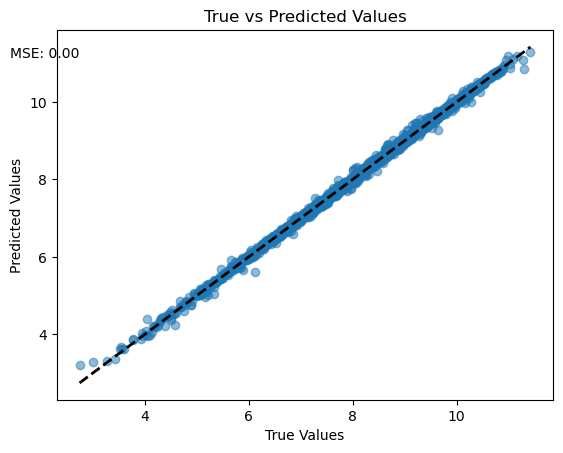

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred = rf_model.predict(X_test)

# Evaluate the model (for example, using Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


import matplotlib.pyplot as plt

# Scatter plot of true vs predicted values
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('True vs Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# Plot a diagonal line for reference
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--k', linewidth=2)

# Display the MSE score on the plot
plt.text(min(y_test), max(y_test), f'MSE: {mse:.2f}', verticalalignment='top', horizontalalignment='right')

# Show the plot
plt.show()


In [13]:
from sklearn.metrics import r2_score

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Print the R-squared value
print(f"R-squared: {r2}")


R-squared: 0.9987203289396436


In [14]:
# Create a DataFrame for the new data including temperature
new_df = pd.DataFrame({
    'Wind': last_120_wind_flat,
    'Rain': last_120_rain_flat,
    'Hurs': last_120_hurs_flat,
    'Temp': last_120_temp_flat,  # Include temperature
    'Temp_Max': last_120_temp_max_flat,
    'Temp_Min': last_120_temp_min_flat,
    'Sun': last_120_sun_flat,
    'Frost': last_120_frost_flat,
    'Psl': last_120_psl_flat
})

# Lagged features
lags = 12  # Adjust based on the expected temporal patterns
variables_to_lag = ['Hurs', 'Rain', 'Temp_Max', 'Temp_Min', 'Sun', 'Frost', 'Wind', 'Psl']

# Create a list to store lagged DataFrames
lagged_dfs = []

for var in variables_to_lag:
    # Create lagged features and store in a new DataFrame
    lagged_var_df = pd.DataFrame({f'{var}_Lag_{i}': df[var].shift(i) for i in range(1, lags + 1)})
    lagged_dfs.append(lagged_var_df)

# Concatenate lagged DataFrames along columns
new_df = pd.concat([new_df] + lagged_dfs, axis=1)

# Drop rows with NaN values introduced by lagging
new_df = new_df.dropna()

# Separate the temperature column before prediction
X_temp = new_df['Temp'].values.reshape(-1, 1)
X_new = new_df.drop(['Temp'], axis=1).values

In [15]:
# Assuming rf_model is your trained Random Forest model
future_predictions = rf_model.predict(X_new)

print(future_predictions)
print(future_predictions.shape)

[11.30386476 11.31713796 11.30546089 ... 11.33065605 11.33433505
 11.33921852]
(5848,)


In [16]:
X_new.shape

(5848, 104)

In [17]:
X_temp.shape

(5848, 1)

In [18]:
import pandas as pd

# Assuming X_temp and future_predictions are NumPy arrays
comparison_df = pd.DataFrame({
    'Actual_Temp': X_temp.flatten(),  # Flatten to make sure it's a 1D array
    'Predicted_Temp': future_predictions
})

# Display the DataFrame
print(comparison_df)


      Actual_Temp  Predicted_Temp
0        9.771922       11.303865
1       10.574474       11.317138
2       10.439654       11.305461
3        9.946073       11.316923
4        9.735766       11.313024
...           ...             ...
5843     7.209711       11.337339
5844     7.641147       11.334594
5845     7.402051       11.330656
5846     7.331370       11.334335
5847     7.796477       11.339219

[5848 rows x 2 columns]


In [19]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

r2 = r2_score(comparison_df['Actual_Temp'], comparison_df['Predicted_Temp'])
print(f"R-squared: {r2}")


mae = mean_absolute_error(comparison_df['Actual_Temp'], comparison_df['Predicted_Temp'])
print(f"Mean Absolute Error: {mae}")


mse = mean_squared_error(comparison_df['Actual_Temp'], comparison_df['Predicted_Temp'])
print(f"Mean Squared Error: {mse}")


R-squared: -4.84693389292799
Mean Absolute Error: 2.4680411984481245
Mean Squared Error: 7.348588322351502


Text(0, 0.5, 'Residuals')

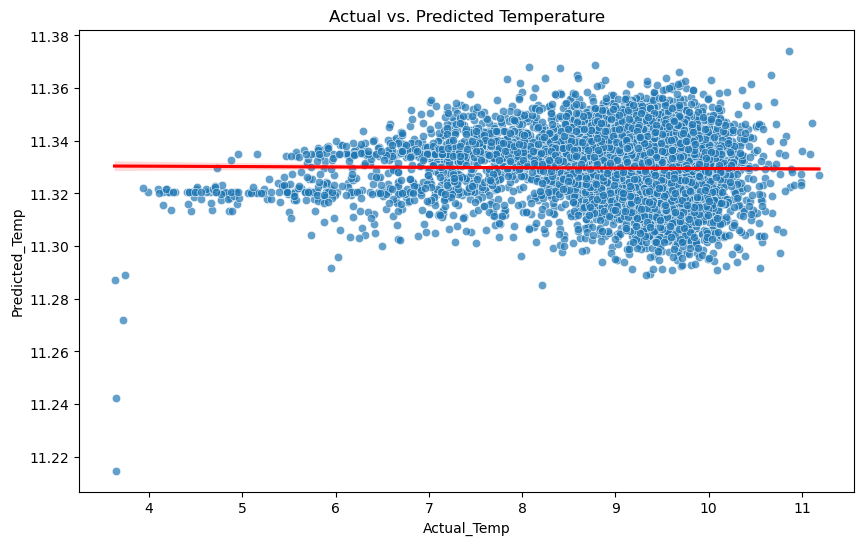

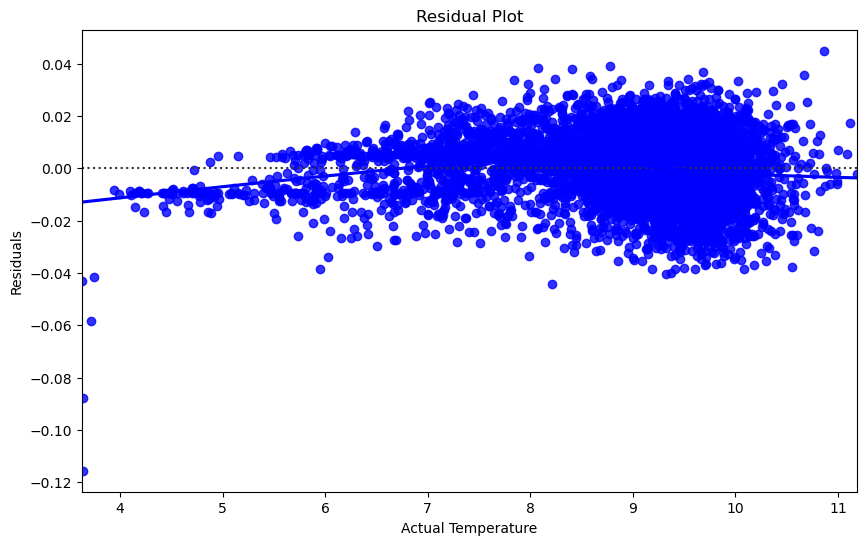

In [20]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual_Temp', y='Predicted_Temp', data=comparison_df, alpha=0.7)
plt.title('Actual vs. Predicted Temperature')
plt.xlabel('Actual Temperature')
plt.ylabel('Predicted Temperature')

# Regression line
sns.regplot(x='Actual_Temp', y='Predicted_Temp', data=comparison_df, scatter=False, color='red')

# Residual plot
plt.figure(figsize=(10, 6))
sns.residplot(x='Actual_Temp', y='Predicted_Temp', data=comparison_df, lowess=True, color='blue')
plt.title('Residual Plot')
plt.xlabel('Actual Temperature')
plt.ylabel('Residuals')


## Entire U.K. Average

In [ ]:
from sklearn.model_selection import train_test_split
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from skimage.measure import block_reduce
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import sem
from scipy.stats import t

data_temp = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Temp\*.nc", parallel=True)
data_tmax = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmax\*.nc", parallel=True)
data_tmin = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmin\*.nc", parallel=True)
data_rain = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Rain\*.nc", parallel=True)
data_hurs = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Humidity\*.nc", parallel=True)
data_sun = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Sun\*.nc", parallel=True)
data_frost = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Frost\*.nc", parallel=True)
data_psl = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_psl\*.nc", parallel=True)
data_wind = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Wind\*.nc", parallel=True)

In [22]:
rain = np.array(data_rain['rainfall'])
hurs = np.array(data_hurs['hurs'])
temp = np.array(data_temp['tas'])
temp_max = np.array(data_tmax['tasmax'])
temp_min = np.array(data_tmin['tasmin'])
sun = np.array(data_sun['sun'])
frost = np.array(data_frost['groundfrost'])
psl = np.array(data_psl['psl'])
wind = np.array(data_wind['sfcWind'])

In [23]:
temp = block_reduce(temp, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp))
temp_max = block_reduce(temp_max, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp_max))
temp_min = block_reduce(temp_min, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp_min))
rain = block_reduce(rain, block_size=(12, 1, 1), func=np.mean, cval=np.mean(rain))
hurs = block_reduce(hurs, block_size=(12, 1, 1), func=np.mean, cval=np.mean(hurs))
sun = block_reduce(sun, block_size=(12, 1, 1), func=np.mean, cval=np.mean(sun))
frost = block_reduce(frost, block_size=(12, 1, 1), func=np.mean, cval=np.mean(frost))
psl = block_reduce(psl, block_size=(12, 1, 1), func=np.mean, cval=np.mean(psl))
wind = block_reduce(wind, block_size=(12, 1, 1), func=np.mean, cval=np.mean(wind))

In [24]:
temp = np.nanmean(temp, axis=(1, 2))
temp_max = np.nanmean(temp_max, axis=(1,2))
temp_min = np.nanmean(temp_min, axis=(1,2))
rain = np.nanmean(rain, axis=(1,2))
hurs = np.nanmean(hurs, axis=(1,2))
sun = np.nanmean(sun, axis=(1,2))
frost = np.nanmean(frost, axis=(1,2))
psl = np.nanmean(psl, axis=(1,2))
wind = np.nanmean(wind, axis=(1,2))

In [25]:
min_length = len(wind)
rain = rain[:min_length]
hurs = hurs[:min_length]
temp = temp[:min_length]
temp_max = temp_max[:min_length]
temp_min = temp_min[:min_length]
sun = sun[:min_length]
frost = frost[:min_length]
wind = wind[:min_length]
psl = psl[:min_length]

In [26]:
wind.shape

(54,)

In [27]:
last_120_wind = wind[-10:]
last_120_rain = rain[-10:]
last_120_hurs = hurs[-10:]
last_120_temp = temp[-10:]
last_120_temp_max = temp_max[-10:]
last_120_temp_min = temp_min[-10:]
last_120_sun = sun[-10:]
last_120_frost = frost[-10:]
last_120_psl = psl[-10:]

In [28]:
wind = wind[:-10]
rain = rain[:-10]
hurs = hurs[:-10]
temp = temp[:-10]
temp_max = temp_max[:-10]
temp_min = temp_min[:-10]
sun = sun[:-10]
frost = frost[:-10]
psl = psl[:-10]


In [29]:
wind.shape

(44,)

In [30]:
df = pd.DataFrame({
    'Rain': rain,
    'Hurs': hurs,
    'Temp': temp,
    'Temp_Max': temp_max,
    'Temp_Min': temp_min,
    'Sun': sun,
    'Frost': frost,
    'Wind': wind,
    'Psl': psl
})

# Lagged features
lags = 9  # Adjust based on the expected temporal patterns
variables_to_lag = ['Hurs', 'Rain', 'Temp_Max', 'Temp_Min', 'Sun', 'Frost', 'Wind', 'Psl']

# Create a list to store lagged DataFrames
lagged_dfs = []

for var in variables_to_lag:
    # Create lagged features and store in a new DataFrame
    lagged_var_df = pd.DataFrame({f'{var}_Lag_{i}': df[var].shift(i) for i in range(1, lags + 1)})
    lagged_dfs.append(lagged_var_df)

# Concatenate lagged DataFrames along columns
df = pd.concat([df] + lagged_dfs, axis=1)

# Drop rows with NaN values introduced by lagging
df = df.dropna()

# Target variable (future temperatures over the entire grid)
y = df['Temp'].values

# Features
X = df.drop(['Temp'], axis=1).values

# Display the DataFrame (optional)
print(df.head())


         Rain       Hurs      Temp   Temp_Max  Temp_Min         Sun  \
9   86.243187  83.427779  8.750207  12.838864  4.709172  114.907213   
10  88.933301  83.533916  8.160631  11.904184  4.470072  102.259552   
11  80.728978  83.429417  7.493051  11.476708  3.583091  122.976522   
12  98.786154  82.823855  8.248645  12.000842  4.575148  108.833815   
13  83.030737  82.555451  8.205667  11.891442  4.576033  105.814065   

        Frost      Wind          Psl  Hurs_Lag_1  ...  Wind_Lag_9  \
9    9.871324  5.020279  1012.752102   83.790113  ...    4.907312   
10   9.047407  5.161575  1015.525351   83.427779  ...    5.188980   
11   9.381932  5.076797  1013.569310   83.533916  ...    4.755948   
12  10.391473  5.090883  1016.914965   83.429417  ...    4.953476   
13   9.160236  4.987185  1011.952350   82.823855  ...    4.855272   

      Psl_Lag_1    Psl_Lag_2    Psl_Lag_3    Psl_Lag_4    Psl_Lag_5  \
9   1013.610834  1013.841881  1012.882837  1011.443794  1012.440568   
10  1012.752102 

Mean Squared Error: 0.09839273245914228
R-squared: 0.3899475414283692


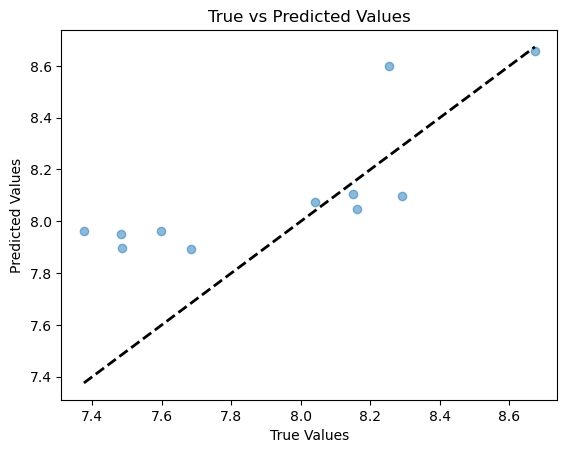

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred = rf_model.predict(X_test)

# Evaluate the model (for example, using Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Print the R-squared value
print(f"R-squared: {r2}")


# Scatter plot of true vs predicted values
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('True vs Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# Plot a diagonal line for reference
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--k', linewidth=2)


# Show the plot
plt.show()


In [33]:
df

,Rain,Hurs,Temp,Temp_Max,Temp_Min,Sun,Frost,Wind,Psl,Hurs_Lag_1,...,Wind_Lag_9,Psl_Lag_1,Psl_Lag_2,Psl_Lag_3,Psl_Lag_4,Psl_Lag_5,Psl_Lag_6,Psl_Lag_7,Psl_Lag_8,Psl_Lag_9
9,86.243187,83.427779,8.750207,12.838864,4.709172,114.907213,9.871324,5.020279,1012.752102,83.790113,...,4.907312,1013.610834,1013.841881,1012.882837,1011.443794,1012.440568,1015.645590,1012.927052,1014.982762,1013.152372
10,88.933301,83.533916,8.160631,11.904184,4.470072,102.259552,9.047407,5.161575,1015.525351,83.427779,...,5.188980,1012.752102,1013.610834,1013.841881,1012.882837,1011.443794,1012.440568,1015.645590,1012.927052,1014.982762
11,80.728978,83.429417,7.493051,11.476708,3.583091,122.976522,9.381932,5.076797,1013.569310,83.533916,...,4.755948,1015.525351,1012.752102,1013.610834,1013.841881,1012.882837,1011.443794,1012.440568,1015.645590,1012.927052
12,98.786154,82.823855,8.248645,12.000842,4.575148,108.833815,10.391473,5.090883,1016.914965,83.429417,...,4.953476,1013.569310,1015.525351,1012.752102,1013.610834,1013.841881,1012.882837,1011.443794,1012.440568,1015.645590
13,83.030737,82.555451,8.205667,11.891442,4.576033,105.814065,9.160236,4.987185,1011.952350,82.823855,...,4.855272,1016.914965,1013.569310,1015.525351,1012.752102,1013.610834,1013.841881,1012.882837,1011.443794,1012.440568
14,79.604363,82.530156,8.839535,12.589455,5.138052,101.941602,10.142004,5.136326,1016.521341,82.555451,...,5.458642,1011.952350,1016.914965,1013.569310,1015.525351,1012.752102,1013.610834,1013.841881,1012.882837,1011.443794
15,75.939807,81.893746,8.550383,12.563592,4.599697,113.681723,9.908445,4.654632,1014.908059,82.530156,...,4.869429,1016.521341,1011.952350,1016.914965,1013.569310,1015.525351,1012.752102,1013.610834,1013.841881,1012.882837
16,105.073392,83.231109,8.237909,11.952649,4.574730,107.526309,9.347098,4.705839,1012.669043,81.893746,...,4.870563,1014.908059,1016.521341,1011.952350,1016.914965,1013.569310,1015.525351,1012.752102,1013.610834,1013.841881
17,78.745826,84.174001,8.039716,11.920222,4.219263,103.785280,9.213711,5.348541,1012.818885,83.231109,...,5.392750,1012.669043,1014.908059,1016.521341,1011.952350,1016.914965,1013.569310,1015.525351,1012.752102,1013.610834
18,75.704386,83.767062,7.684511,11.263836,4.141805,113.416503,11.689648,4.436863,1011.606891,84.174001,...,5.020279,1012.818885,1012.669043,1014.908059,1016.521341,1011.952350,1016.914965,1013.569310,1015.525351,1012.752102


In [34]:
# Create a DataFrame for the new data including temperature
new_df = pd.DataFrame({
    'Wind': last_120_wind,
    'Rain': last_120_rain,
    'Hurs': last_120_hurs,
    'Temp': last_120_temp,  # Include temperature
    'Temp_Max': last_120_temp_max,
    'Temp_Min': last_120_temp_min,
    'Sun': last_120_sun,
    'Frost': last_120_frost,
    'Psl': last_120_psl
})

print(new_df.shape)


lags = 9  # Adjust based on the expected temporal patterns
variables_to_lag = ['Hurs', 'Rain', 'Temp_Max', 'Temp_Min', 'Sun', 'Frost', 'Wind', 'Psl']

# Create a list to store lagged DataFrames
lagged_dfs = []

for var in variables_to_lag:
    # Create lagged features and store in a new DataFrame
    lagged_var_df = pd.DataFrame({f'{var}_Lag_{i}': new_df[var].shift(i) for i in range(1, lags + 1)})
    lagged_dfs.append(lagged_var_df)

# Concatenate lagged DataFrames along columns
new_df = pd.concat([new_df] + lagged_dfs, axis=1)

from sklearn.impute import KNNImputer

# Create the imputer
knn_imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors

# Fit and transform your DataFrame
new_df = pd.DataFrame(knn_imputer.fit_transform(new_df), columns=new_df.columns)

# Separate the temperature column before prediction
X_temp = new_df['Temp'].values.reshape(-1, 1)
X_new = new_df.drop(['Temp'], axis=1).values


(10, 9)


In [35]:
# Assuming rf_model is your trained Random Forest model
future_predictions = rf_model.predict(X_new)

print(future_predictions)
print(future_predictions.shape)

[8.75696627 8.73574533 8.75233209 8.76134899 8.7342472  8.7571542
 8.74160844 8.75033268 8.77593944 8.71784985]
(10,)


In [36]:

import pandas as pd

# Assuming X_temp and future_predictions are NumPy arrays
comparison_df = pd.DataFrame({
    'Actual_Temp': X_temp.flatten(),  
    'Predicted_Temp': future_predictions
})

# Display the DataFrame
print(comparison_df)


   Actual_Temp  Predicted_Temp
0     8.331636        8.756966
1     7.926364        8.735745
2     8.240718        8.752332
3     7.946173        8.761349
4     8.321629        8.734247
5     8.786913        8.757154
6     8.826152        8.741608
7     8.489316        8.750333
8     8.222669        8.775939
9     8.301653        8.717850


In [37]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

r2 = r2_score(comparison_df['Actual_Temp'], comparison_df['Predicted_Temp'])
print(f"R-squared: {r2}")


mae = mean_absolute_error(comparison_df['Actual_Temp'], comparison_df['Predicted_Temp'])
print(f"Mean Absolute Error: {mae}")


mse = mean_squared_error(comparison_df['Actual_Temp'], comparison_df['Predicted_Temp'])
print(f"Mean Squared Error: {mse}")


R-squared: -2.0713834936401168
Mean Absolute Error: 0.43189048139361114
Mean Squared Error: 0.2488008329453173


Text(0, 0.5, 'Residuals')

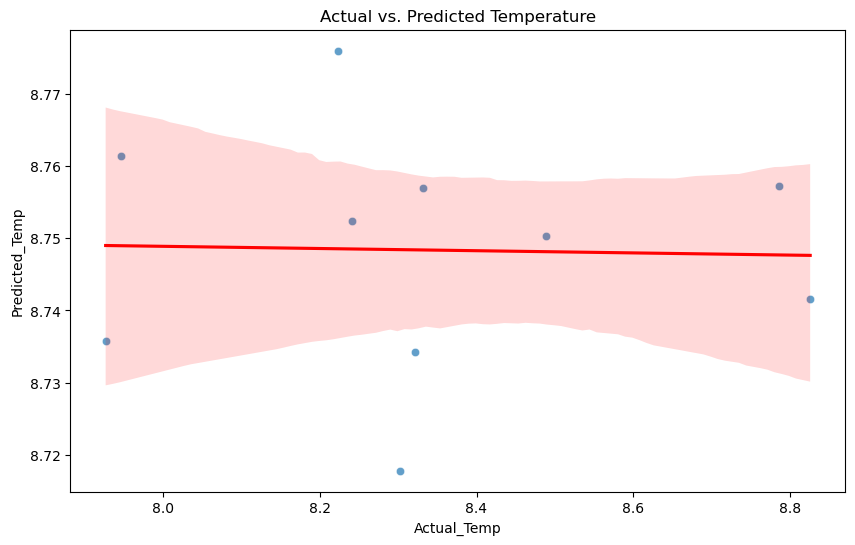

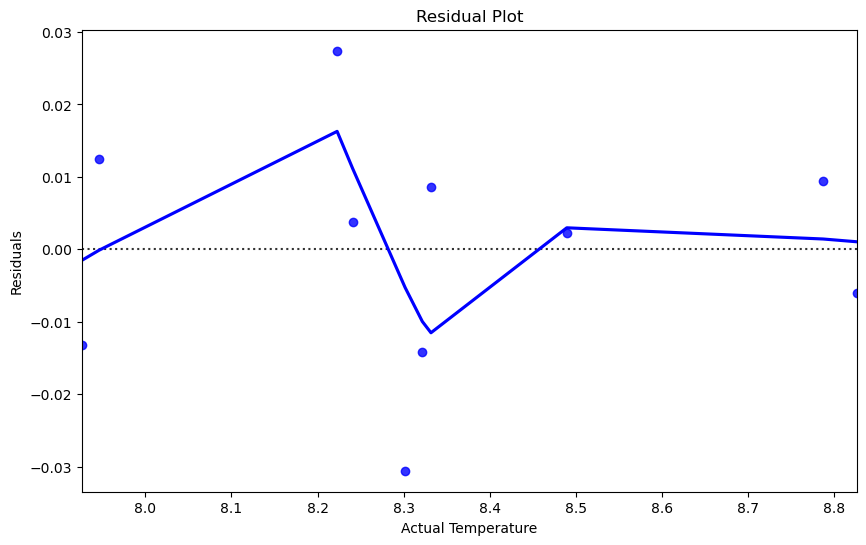

In [38]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual_Temp', y='Predicted_Temp', data=comparison_df, alpha=0.7)
plt.title('Actual vs. Predicted Temperature')
plt.xlabel('Actual Temperature')
plt.ylabel('Predicted Temperature')

# Regression line
sns.regplot(x='Actual_Temp', y='Predicted_Temp', data=comparison_df, scatter=False, color='red')

# Residual plot
plt.figure(figsize=(10, 6))
sns.residplot(x='Actual_Temp', y='Predicted_Temp', data=comparison_df, lowess=True, color='blue')
plt.title('Residual Plot')
plt.xlabel('Actual Temperature')
plt.ylabel('Residuals')

## Entire U.K. with Months

In [3]:
from sklearn.model_selection import train_test_split
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from skimage.measure import block_reduce
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import sem
from scipy.stats import t

data_temp = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Temp\*.nc", parallel=True)
data_tmax = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmax\*.nc", parallel=True)
data_tmin = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmin\*.nc", parallel=True)
data_rain = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Rain\*.nc", parallel=True)
data_hurs = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Humidity\*.nc", parallel=True)
data_sun = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Sun\*.nc", parallel=True)
data_frost = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Frost\*.nc", parallel=True)
data_psl = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_psl\*.nc", parallel=True)
data_wind = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Wind\*.nc", parallel=True)

In [71]:
rain = np.array(data_rain['rainfall'])
hurs = np.array(data_hurs['hurs'])
temp = np.array(data_temp['tas'])
temp_max = np.array(data_tmax['tasmax'])
temp_min = np.array(data_tmin['tasmin'])
sun = np.array(data_sun['sun'])
frost = np.array(data_frost['groundfrost'])
psl = np.array(data_psl['psl'])
wind = np.array(data_wind['sfcWind'])

In [72]:
variables = ['wind', 'rain', 'hurs', 'temp', 'temp_max', 'temp_min', 'sun', 'frost', 'psl']
data = [wind, rain, hurs, temp, temp_max, temp_min, sun, frost, psl]

# Reshape the data to have 12 months
reshaped_data = {var: data[i].reshape(12, -1, 112, 82) for i, var in enumerate(variables)}

# Create separate arrays for each month dynamically
monthly_data = {f"{var}_{month+1}": reshaped_data[var][month] for var in variables for month in range(12)}


In [73]:
# Create separate arrays for each month and variable
wind_january, wind_february, wind_march, wind_april, wind_may, wind_june, wind_july, wind_august, wind_september, wind_october, wind_november, wind_december = reshaped_data['wind']
rain_january, rain_february, rain_march, rain_april, rain_may, rain_june, rain_july, rain_august, rain_september, rain_october, rain_november, rain_december = reshaped_data['rain']
hurs_january, hurs_february, hurs_march, hurs_april, hurs_may, hurs_june, hurs_july, hurs_august, hurs_september, hurs_october, hurs_november, hurs_december = reshaped_data['hurs']
temp_january, temp_february, temp_march, temp_april, temp_may, temp_june, temp_july, temp_august, temp_september, temp_october, temp_november, temp_december = reshaped_data['temp']
temp_max_january, temp_max_february, temp_max_march, temp_max_april, temp_max_may, temp_max_june, temp_max_july, temp_max_august, temp_max_september, temp_max_october, temp_max_november, temp_max_december = reshaped_data['temp_max']
temp_min_january, temp_min_february, temp_min_march, temp_min_april, temp_min_may, temp_min_june, temp_min_july, temp_min_august, temp_min_september, temp_min_october, temp_min_november, temp_min_december = reshaped_data['temp_min']
sun_january, sun_february, sun_march, sun_april, sun_may, sun_june, sun_july, sun_august, sun_september, sun_october, sun_november, sun_december = reshaped_data['sun']
frost_january, frost_february, frost_march, frost_april, frost_may, frost_june, frost_july, frost_august, frost_september, frost_october, frost_november, frost_december = reshaped_data['frost']
psl_january, psl_february, psl_march, psl_april, psl_may, psl_june, psl_july, psl_august, psl_september, psl_october, psl_november, psl_december = reshaped_data['psl']

In [74]:
temp = block_reduce(temp, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp))
temp_max = block_reduce(temp_max, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp_max))
temp_min = block_reduce(temp_min, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp_min))
rain = block_reduce(rain, block_size=(12, 1, 1), func=np.mean, cval=np.mean(rain))
hurs = block_reduce(hurs, block_size=(12, 1, 1), func=np.mean, cval=np.mean(hurs))
sun = block_reduce(sun, block_size=(12, 1, 1), func=np.mean, cval=np.mean(sun))
frost = block_reduce(frost, block_size=(12, 1, 1), func=np.mean, cval=np.mean(frost))
psl = block_reduce(psl, block_size=(12, 1, 1), func=np.mean, cval=np.mean(psl))
wind = block_reduce(wind, block_size=(12, 1, 1), func=np.mean, cval=np.mean(wind))

In [75]:
temp.shape

(139, 112, 82)

In [76]:
rain = np.nanmean(rain, axis=(1, 2))
hurs = np.nanmean(hurs, axis=(1, 2))
temp_max = np.nanmean(temp_max, axis=(1, 2))
temp_min = np.nanmean(temp_min, axis=(1, 2))
temp = np.nanmean(temp, axis=(1,2))
sun = np.nanmean(sun, axis=(1, 2))
frost = np.nanmean(frost, axis=(1, 2))
psl = np.nanmean(psl, axis=(1, 2))
wind = np.nanmean(wind, axis=(1, 2))

# List of variable names
variables = ['wind', 'rain', 'hurs', 'temp', 'temp_max', 'temp_min', 'sun', 'frost', 'psl']

# List of month names
months = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']

# Create a dictionary to store the results
means = {}

# Loop over variables
for variable in variables:
    means[variable] = {}
    
    # Loop over months
    for month in months:
        # Get the array for the current variable and month, e.g., wind_jan
        current_array = globals()[f"{variable}_{month}"]
        
        # Calculate the mean over axis (1, 2)
        current_mean = np.nanmean(current_array, axis=(1, 2))
        
        # Store the result in the dictionary
        means[variable][month] = current_mean


In [77]:
wind_january_mean, wind_february_mean, wind_march_mean, wind_april_mean, wind_may_mean, wind_june_mean, wind_july_mean, wind_august_mean, wind_september_mean, wind_october_mean, wind_november_mean, wind_december_mean = means['wind']['january'], means['wind']['february'], means['wind']['march'], means['wind']['april'], means['wind']['may'], means['wind']['june'], means['wind']['july'], means['wind']['august'], means['wind']['september'], means['wind']['october'], means['wind']['november'], means['wind']['december']
rain_january_mean, rain_february_mean, rain_march_mean, rain_april_mean, rain_may_mean, rain_june_mean, rain_july_mean, rain_august_mean, rain_september_mean, rain_october_mean, rain_november_mean, rain_december_mean = means['rain']['january'], means['rain']['february'], means['rain']['march'], means['rain']['april'], means['rain']['may'], means['rain']['june'], means['rain']['july'], means['rain']['august'], means['rain']['september'], means['rain']['october'], means['rain']['november'], means['rain']['december']
hurs_january_mean, hurs_february_mean, hurs_march_mean, hurs_april_mean, hurs_may_mean, hurs_june_mean, hurs_july_mean, hurs_august_mean, hurs_september_mean, hurs_october_mean, hurs_november_mean, hurs_december_mean = means['hurs']['january'], means['hurs']['february'], means['hurs']['march'], means['hurs']['april'], means['hurs']['may'], means['hurs']['june'], means['hurs']['july'], means['hurs']['august'], means['hurs']['september'], means['hurs']['october'], means['hurs']['november'], means['hurs']['december']
temp_january_mean, temp_february_mean, temp_march_mean, temp_april_mean, temp_may_mean, temp_june_mean, temp_july_mean, temp_august_mean, temp_september_mean, temp_october_mean, temp_november_mean, temp_december_mean = means['temp']['january'], means['temp']['february'], means['temp']['march'], means['temp']['april'], means['temp']['may'], means['temp']['june'], means['temp']['july'], means['temp']['august'], means['temp']['september'], means['temp']['october'], means['temp']['november'], means['temp']['december']
temp_max_january_mean, temp_max_february_mean, temp_max_march_mean, temp_max_april_mean, temp_max_may_mean, temp_max_june_mean, temp_max_july_mean, temp_max_august_mean, temp_max_september_mean, temp_max_october_mean, temp_max_november_mean, temp_max_december_mean = means['temp_max']['january'], means['temp_max']['february'], means['temp_max']['march'], means['temp_max']['april'], means['temp_max']['may'], means['temp_max']['june'], means['temp_max']['july'], means['temp_max']['august'], means['temp_max']['september'], means['temp_max']['october'], means['temp_max']['november'], means['temp_max']['december']
temp_min_january_mean, temp_min_february_mean, temp_min_march_mean, temp_min_april_mean, temp_min_may_mean, temp_min_june_mean, temp_min_july_mean, temp_min_august_mean, temp_min_september_mean, temp_min_october_mean, temp_min_november_mean, temp_min_december_mean = means['temp_min']['january'], means['temp_min']['february'], means['temp_min']['march'], means['temp_min']['april'], means['temp_min']['may'], means['temp_min']['june'], means['temp_min']['july'], means['temp_min']['august'], means['temp_min']['september'], means['temp_min']['october'], means['temp_min']['november'], means['temp_min']['december']
sun_january_mean, sun_february_mean, sun_march_mean, sun_april_mean, sun_may_mean, sun_june_mean, sun_july_mean, sun_august_mean, sun_september_mean, sun_october_mean, sun_november_mean, sun_december_mean = means['sun']['january'], means['sun']['february'], means['sun']['march'], means['sun']['april'], means['sun']['may'], means['sun']['june'], means['sun']['july'], means['sun']['august'], means['sun']['september'], means['sun']['october'], means['sun']['november'], means['sun']['december']
frost_january_mean, frost_february_mean, frost_march_mean, frost_april_mean, frost_may_mean, frost_june_mean, frost_july_mean, frost_august_mean, frost_september_mean, frost_october_mean, frost_november_mean, frost_december_mean = means['frost']['january'], means['frost']['february'], means['frost']['march'], means['frost']['april'], means['frost']['may'], means['frost']['june'], means['frost']['july'], means['frost']['august'], means['frost']['september'], means['frost']['october'], means['frost']['november'], means['frost']['december']
psl_january_mean, psl_february_mean, psl_march_mean, psl_april_mean, psl_may_mean, psl_june_mean, psl_july_mean, psl_august_mean, psl_september_mean, psl_october_mean, psl_november_mean, psl_december_mean = means['psl']['january'], means['psl']['february'], means['psl']['march'], means['psl']['april'], means['psl']['may'], means['psl']['june'], means['psl']['july'], means['psl']['august'], means['psl']['september'], means['psl']['october'], means['psl']['november'], means['psl']['december']

In [78]:
min_length = len(wind)
rain = rain[:min_length]
hurs = hurs[:min_length]
temp = temp[:min_length]
temp_max = temp_max[:min_length]
temp_min = temp_min[:min_length]
sun = sun[:min_length]
frost = frost[:min_length]
wind = wind[:min_length]
psl = psl[:min_length]

In [79]:
temp.shape

(54,)

In [91]:
# Original code to trim mean arrays to minimum length
# List of variable names
variables = ['wind_january_mean', 'wind_february_mean', 'wind_march_mean', 'wind_april_mean', 'wind_may_mean', 'wind_june_mean', 'wind_july_mean', 'wind_august_mean', 'wind_september_mean', 'wind_october_mean', 'wind_november_mean', 'wind_december_mean',
                'rain_january_mean', 'rain_february_mean', 'rain_march_mean', 'rain_april_mean', 'rain_may_mean', 'rain_june_mean', 'rain_july_mean', 'rain_august_mean', 'rain_september_mean', 'rain_october_mean', 'rain_november_mean', 'rain_december_mean',
                 'hurs_january_mean', 'hurs_february_mean', 'hurs_march_mean', 'hurs_april_mean', 'hurs_may_mean', 'hurs_june_mean', 'hurs_july_mean', 'hurs_august_mean', 'hurs_september_mean', 'hurs_october_mean', 'hurs_november_mean', 'hurs_december_mean',
                 'temp_january_mean', 'temp_february_mean', 'temp_march_mean', 'temp_april_mean', 'temp_may_mean', 'temp_june_mean', 'temp_july_mean', 'temp_august_mean', 'temp_september_mean', 'temp_october_mean', 'temp_november_mean', 'temp_december_mean',
                 'temp_max_january_mean', 'temp_max_february_mean', 'temp_max_march_mean', 'temp_max_april_mean', 'temp_max_may_mean', 'temp_max_june_mean', 'temp_max_july_mean', 'temp_max_august_mean', 'temp_max_september_mean', 'temp_max_october_mean', 'temp_max_november_mean', 'temp_max_december_mean',
                 'temp_min_january_mean', 'temp_min_february_mean', 'temp_min_march_mean', 'temp_min_april_mean', 'temp_min_may_mean', 'temp_min_june_mean', 'temp_min_july_mean', 'temp_min_august_mean', 'temp_min_september_mean', 'temp_min_october_mean', 'temp_min_november_mean', 'temp_min_december_mean',
                 'sun_january_mean', 'sun_february_mean', 'sun_march_mean', 'sun_april_mean', 'sun_may_mean', 'sun_june_mean', 'sun_july_mean', 'sun_august_mean', 'sun_september_mean', 'sun_october_mean', 'sun_november_mean', 'sun_december_mean',
                 'frost_january_mean', 'frost_february_mean', 'frost_march_mean', 'frost_april_mean', 'frost_may_mean', 'frost_june_mean', 'frost_july_mean', 'frost_august_mean', 'frost_september_mean', 'frost_october_mean', 'frost_november_mean', 'frost_december_mean',
                 'psl_january_mean', 'psl_february_mean', 'psl_march_mean', 'psl_april_mean', 'psl_may_mean', 'psl_june_mean', 'psl_july_mean', 'psl_august_mean', 'psl_september_mean', 'psl_october_mean', 'psl_november_mean', 'psl_december_mean']

# Loop over variables
for variable in variables:
    # Extract the variable name and month
    parts = variable.split('_')
    
    if len(parts) >= 2:
        current_variable, current_month = '_'.join(parts[:-1]), parts[-1]
        
        # Check if the current_month is a valid month
        if current_month in months:
            # Get the current mean array, e.g., wind_january_mean
            current_mean_array = means[current_variable][current_month]

            # Trim the mean array to the minimum length
            means[current_variable][current_month] = current_mean_array[:min_length]


import pandas as pd

# List of all variable names including monthly variables
variables = ['wind', 'rain', 'hurs', 'temp', 'temp_max', 'temp_min', 'sun', 'frost', 'psl']
monthly_means = ['wind_january_mean', 'wind_february_mean', 'wind_march_mean', 'wind_april_mean', 'wind_may_mean', 'wind_june_mean', 'wind_july_mean', 'wind_august_mean', 'wind_september_mean', 'wind_october_mean', 'wind_november_mean', 'wind_december_mean',
                 'rain_january_mean', 'rain_february_mean', 'rain_march_mean', 'rain_april_mean', 'rain_may_mean', 'rain_june_mean', 'rain_july_mean', 'rain_august_mean', 'rain_september_mean', 'rain_october_mean', 'rain_november_mean', 'rain_december_mean',
                 'hurs_january_mean', 'hurs_february_mean', 'hurs_march_mean', 'hurs_april_mean', 'hurs_may_mean', 'hurs_june_mean', 'hurs_july_mean', 'hurs_august_mean', 'hurs_september_mean', 'hurs_october_mean', 'hurs_november_mean', 'hurs_december_mean',
                 'temp_january_mean', 'temp_february_mean', 'temp_march_mean', 'temp_april_mean', 'temp_may_mean', 'temp_june_mean', 'temp_july_mean', 'temp_august_mean', 'temp_september_mean', 'temp_october_mean', 'temp_november_mean', 'temp_december_mean',
                 'temp_max_january_mean', 'temp_max_february_mean', 'temp_max_march_mean', 'temp_max_april_mean', 'temp_max_may_mean', 'temp_max_june_mean', 'temp_max_july_mean', 'temp_max_august_mean', 'temp_max_september_mean', 'temp_max_october_mean', 'temp_max_november_mean', 'temp_max_december_mean',
                 'temp_min_january_mean', 'temp_min_february_mean', 'temp_min_march_mean', 'temp_min_april_mean', 'temp_min_may_mean', 'temp_min_june_mean', 'temp_min_july_mean', 'temp_min_august_mean', 'temp_min_september_mean', 'temp_min_october_mean', 'temp_min_november_mean', 'temp_min_december_mean',
                 'sun_january_mean', 'sun_february_mean', 'sun_march_mean', 'sun_april_mean', 'sun_may_mean', 'sun_june_mean', 'sun_july_mean', 'sun_august_mean', 'sun_september_mean', 'sun_october_mean', 'sun_november_mean', 'sun_december_mean',
                 'frost_january_mean', 'frost_february_mean', 'frost_march_mean', 'frost_april_mean', 'frost_may_mean', 'frost_june_mean', 'frost_july_mean', 'frost_august_mean', 'frost_september_mean', 'frost_october_mean', 'frost_november_mean', 'frost_december_mean',
                 'psl_january_mean', 'psl_february_mean', 'psl_march_mean', 'psl_april_mean', 'psl_may_mean', 'psl_june_mean', 'psl_july_mean', 'psl_august_mean', 'psl_september_mean', 'psl_october_mean', 'psl_november_mean', 'psl_december_mean']

# Combine all variables
all_variables = variables + monthly_means

# Create a dictionary to store the original arrays
original_arrays = {}

# Loop over all variables
for var in all_variables:
    # Store the original array
    original_arrays[var] = globals()[var]

# Create dictionaries to store the trimmed and added elements
trimmed_arrays = {}
last_10_values = {}

min_length = len(original_arrays['wind'])  # Assuming 'wind' is the reference array

# Loop over all variables
for var in all_variables:
    # Store the trimmed arrays (first min_length values)
    trimmed_arrays[var] = original_arrays[var][:min_length]
    
    # Store the last 10 values (excluding the last 10 values from trimmed arrays)
    last_10_values[var] = original_arrays[var][-10:]

    # Remove the last 10 values from the trimmed arrays
    trimmed_arrays[var] = trimmed_arrays[var][:-10]
    
trimmed_df = pd.DataFrame(trimmed_arrays)
last_10_df = pd.DataFrame(last_10_values)

Length of wind: 44
Length of rain: 44
Length of hurs: 44
Length of temp: 44
Length of temp_max: 44
Length of temp_min: 44
Length of sun: 44
Length of frost: 44
Length of psl: 44
Length of wind_january_mean: 44
Length of wind_february_mean: 44
Length of wind_march_mean: 44
Length of wind_april_mean: 44
Length of wind_may_mean: 44
Length of wind_june_mean: 44
Length of wind_july_mean: 44
Length of wind_august_mean: 44
Length of wind_september_mean: 44
Length of wind_october_mean: 44
Length of wind_november_mean: 44
Length of wind_december_mean: 44
Length of rain_january_mean: 44
Length of rain_february_mean: 44
Length of rain_march_mean: 44
Length of rain_april_mean: 44
Length of rain_may_mean: 44
Length of rain_june_mean: 44
Length of rain_july_mean: 44
Length of rain_august_mean: 44
Length of rain_september_mean: 44
Length of rain_october_mean: 44
Length of rain_november_mean: 44
Length of rain_december_mean: 44
Length of hurs_january_mean: 44
Length of hurs_february_mean: 44
Length of

In [92]:
trimmed_df

,wind,rain,hurs,temp,temp_max,temp_min,sun,frost,psl,wind_january_mean,...,psl_march_mean,psl_april_mean,psl_may_mean,psl_june_mean,psl_july_mean,psl_august_mean,psl_september_mean,psl_october_mean,psl_november_mean,psl_december_mean
0,4.907312,93.533645,83.442293,8.455583,12.117584,4.860478,109.220991,8.406055,1013.152372,5.188764,...,1012.027411,1017.314064,1009.162344,1010.708250,1028.468069,1020.591267,1009.724733,1009.339111,1012.461321,1013.885597
1,5.188980,75.813828,82.467151,7.349333,11.031123,3.723835,128.192373,10.731591,1014.982762,5.539113,...,1013.921591,1022.457237,1006.043872,1010.915169,1018.654842,1021.569933,1012.376632,1014.854112,1008.769115,1010.900320
2,4.755948,78.266923,83.663673,7.413521,11.004255,3.901555,93.515310,10.339530,1012.927052,5.420572,...,1019.697220,1013.998231,1018.896860,1023.480624,1011.967549,1013.896045,1013.788388,1019.648858,1006.730962,1006.816888
3,4.953476,88.889211,83.402473,7.492683,11.429563,3.623652,99.014107,9.487041,1015.645590,5.290548,...,1012.119850,1002.173607,1002.125352,1014.234011,1010.014820,1010.048952,1015.831653,1022.000735,1005.127834,1016.191956
4,4.855272,74.647093,83.942880,7.264372,10.798293,3.783253,115.134432,10.652018,1012.440568,4.146534,...,1021.747074,1012.646492,1015.435814,1013.576392,1017.773017,1017.414699,1020.726474,1018.509152,1010.788685,1002.642364
5,5.458642,93.636689,84.147084,7.983804,11.605473,4.417289,115.257630,9.174212,1011.443794,4.267553,...,1020.276108,1007.710007,1013.782004,1014.330813,1018.826999,1014.787972,1010.372466,1016.525922,1017.750175,1009.537706
6,4.869429,77.631740,83.625481,7.929806,11.624463,4.300291,98.079428,8.667710,1012.882837,4.627584,...,1014.198249,1008.148592,1011.587655,1018.884826,1015.369955,1019.690205,1002.120009,1006.981674,1010.884021,1018.134692
7,4.870563,84.202830,84.090216,7.589701,11.365623,3.878101,109.222278,9.830366,1013.841881,4.239763,...,1022.443095,1002.291516,1020.864772,1012.272564,1007.774082,1016.127344,1013.646973,1018.759898,1013.516025,1019.129965
8,5.392750,69.653798,83.790113,7.004461,10.805399,3.266734,111.276909,10.654141,1013.610834,4.629954,...,1010.225141,1013.409704,1015.943645,1016.024936,1012.658016,1000.994525,1013.803256,1004.232126,1011.210512,1016.145286
9,5.020279,86.243187,83.427779,8.750207,12.838864,4.709172,114.907213,9.871324,1012.752102,4.888509,...,1007.056696,1012.371277,1013.521462,1014.888242,1011.292225,1008.338500,1017.207870,1010.234995,1017.448881,1014.624513


In [93]:
last_10_df

,wind,rain,hurs,temp,temp_max,temp_min,sun,frost,psl,wind_january_mean,...,psl_march_mean,psl_april_mean,psl_may_mean,psl_june_mean,psl_july_mean,psl_august_mean,psl_september_mean,psl_october_mean,psl_november_mean,psl_december_mean
0,4.834601,86.690861,81.861543,8.331636,12.019215,4.692388,100.345287,8.484588,1015.759422,3.427624,...,1011.022445,1014.949135,1004.959973,1010.810390,1014.430038,1013.269165,1010.440955,1013.560769,1020.872300,1021.515946
1,4.720519,87.422505,81.558932,7.926364,11.810089,4.078036,128.692580,8.110867,1013.381737,4.501244,...,1019.840950,1013.411955,1020.995413,1014.949337,1019.761838,1013.053264,1007.051729,1006.181917,1011.217127,1016.081274
2,5.077425,104.443877,82.745502,8.240718,11.725283,4.805187,110.504980,7.656735,1014.766221,5.643784,...,1015.209021,1019.837879,1007.424563,1025.452392,1016.639227,1014.530973,1008.847441,1017.300931,1012.121463,1016.061602
3,4.526567,94.220402,82.818667,7.946173,11.409120,4.538359,112.821837,9.371727,1012.216213,5.892262,...,1022.830082,1018.383201,1011.515344,1010.077038,1014.022877,1007.196095,1013.699049,1027.244632,1021.427168,1014.310216
4,4.747761,85.571894,83.776019,8.321629,11.876405,4.820485,100.752006,8.692015,1011.578786,4.643774,...,1015.565255,1002.337807,1010.282958,1014.232697,1018.280148,1021.697921,1011.565006,1026.180929,1016.122706,1019.685696
5,4.703949,85.006963,82.736233,8.786913,12.605681,5.016754,127.276079,11.409686,1013.372485,5.571372,...,1017.183470,1022.037281,1017.560200,1017.889841,1010.376990,1023.791280,1005.681604,1004.938840,1011.192991,1017.530369
6,4.525941,91.894731,82.909138,8.826152,12.586717,5.114336,111.187867,7.091708,1013.463286,4.672153,...,1016.604529,1007.243818,1015.910346,1014.690885,1008.160706,1013.608283,1014.603110,1017.123965,1012.418889,1013.048836
7,4.947384,67.751293,83.738650,8.489316,12.174830,4.843119,110.081285,8.914920,1013.346449,5.614673,...,1021.118614,1017.024308,1013.703120,1013.823096,1015.071124,1004.558927,1022.574230,1009.581609,1013.963041,1010.301110
8,4.404922,83.365335,81.377878,8.222669,11.840358,4.647744,111.309865,9.568828,1013.612814,5.506216,...,1012.738759,1015.015759,1022.623001,1006.715810,1022.036772,1014.608904,1009.847076,1012.269692,1011.091516,1003.248320
9,4.698671,78.171466,83.344048,8.301653,11.888651,4.759464,108.214376,6.518477,1010.160164,4.432479,...,1019.386441,1020.717335,1012.548995,1025.240384,1007.515112,1014.522577,1012.045731,1012.427556,1014.074419,1009.424334


In [96]:
# Lagged features
lags = 9 

# Create a list to store lagged DataFrames
lagged_dfs = []

# Loop over all columns in the trimmed_df except 'Temp'
for col in trimmed_df.columns.difference(['temp']):
    # Create lagged features and store in a new DataFrame
    lagged_var_df = pd.DataFrame({f'{col}_Lag_{i}': trimmed_df[col].shift(i) for i in range(1, lags + 1)})
    lagged_dfs.append(lagged_var_df)

# Concatenate lagged DataFrames along columns
lagged_df = pd.concat([trimmed_df] + lagged_dfs, axis=1)

# Drop rows with NaN values introduced by lagging
lagged_df = lagged_df.dropna()

# Target variable (future temperatures over the entire grid)
y = lagged_df['temp'].values

# Features
X = lagged_df.drop(['temp'], axis=1).values

In [111]:
X_df = lagged_df.drop(['temp'], axis=1)


In [113]:
lagged_df

,wind,rain,hurs,temp,temp_max,temp_min,sun,frost,psl,wind_january_mean,...,wind_october_mean_Lag_9,wind_september_mean_Lag_1,wind_september_mean_Lag_2,wind_september_mean_Lag_3,wind_september_mean_Lag_4,wind_september_mean_Lag_5,wind_september_mean_Lag_6,wind_september_mean_Lag_7,wind_september_mean_Lag_8,wind_september_mean_Lag_9
9,5.020279,86.243187,83.427779,8.750207,12.838864,4.709172,114.907213,9.871324,1012.752102,4.888509,...,4.416769,4.569717,4.006977,3.921862,3.895480,4.696826,5.012407,4.716429,5.100342,6.839803
10,5.161575,88.933301,83.533916,8.160631,11.904184,4.470072,102.259552,9.047407,1015.525351,5.806225,...,4.785333,4.821619,4.569717,4.006977,3.921862,3.895480,4.696826,5.012407,4.716429,5.100342
11,5.076797,80.728978,83.429417,7.493051,11.476708,3.583091,122.976522,9.381932,1013.569310,4.842628,...,4.662284,4.857853,4.821619,4.569717,4.006977,3.921862,3.895480,4.696826,5.012407,4.716429
12,5.090883,98.786154,82.823855,8.248645,12.000842,4.575148,108.833815,10.391473,1016.914965,4.836133,...,4.301014,4.369084,4.857853,4.821619,4.569717,4.006977,3.921862,3.895480,4.696826,5.012407
13,4.987185,83.030737,82.555451,8.205667,11.891442,4.576033,105.814065,9.160236,1011.952350,5.928310,...,5.883523,4.434266,4.369084,4.857853,4.821619,4.569717,4.006977,3.921862,3.895480,4.696826
14,5.136326,79.604363,82.530156,8.839535,12.589455,5.138052,101.941602,10.142004,1016.521341,5.787095,...,4.121263,4.683669,4.434266,4.369084,4.857853,4.821619,4.569717,4.006977,3.921862,3.895480
15,4.654632,75.939807,81.893746,8.550383,12.563592,4.599697,113.681723,9.908445,1014.908059,5.829493,...,4.253105,5.263023,4.683669,4.434266,4.369084,4.857853,4.821619,4.569717,4.006977,3.921862
16,4.705839,105.073392,83.231109,8.237909,11.952649,4.574730,107.526309,9.347098,1012.669043,4.972710,...,3.720288,4.990535,5.263023,4.683669,4.434266,4.369084,4.857853,4.821619,4.569717,4.006977
17,5.348541,78.745826,84.174001,8.039716,11.920222,4.219263,103.785280,9.213711,1012.818885,4.316288,...,4.598671,4.634923,4.990535,5.263023,4.683669,4.434266,4.369084,4.857853,4.821619,4.569717
18,4.436863,75.704386,83.767062,7.684511,11.263836,4.141805,113.416503,11.689648,1011.606891,5.304447,...,4.290546,3.704535,4.634923,4.990535,5.263023,4.683669,4.434266,4.369084,4.857853,4.821619


In [112]:
X_df

,wind,rain,hurs,temp_max,temp_min,sun,frost,psl,wind_january_mean,wind_february_mean,...,wind_october_mean_Lag_9,wind_september_mean_Lag_1,wind_september_mean_Lag_2,wind_september_mean_Lag_3,wind_september_mean_Lag_4,wind_september_mean_Lag_5,wind_september_mean_Lag_6,wind_september_mean_Lag_7,wind_september_mean_Lag_8,wind_september_mean_Lag_9
9,5.020279,86.243187,83.427779,12.838864,4.709172,114.907213,9.871324,1012.752102,4.888509,3.884277,...,4.416769,4.569717,4.006977,3.921862,3.895480,4.696826,5.012407,4.716429,5.100342,6.839803
10,5.161575,88.933301,83.533916,11.904184,4.470072,102.259552,9.047407,1015.525351,5.806225,5.081782,...,4.785333,4.821619,4.569717,4.006977,3.921862,3.895480,4.696826,5.012407,4.716429,5.100342
11,5.076797,80.728978,83.429417,11.476708,3.583091,122.976522,9.381932,1013.569310,4.842628,4.649843,...,4.662284,4.857853,4.821619,4.569717,4.006977,3.921862,3.895480,4.696826,5.012407,4.716429
12,5.090883,98.786154,82.823855,12.000842,4.575148,108.833815,10.391473,1016.914965,4.836133,5.160225,...,4.301014,4.369084,4.857853,4.821619,4.569717,4.006977,3.921862,3.895480,4.696826,5.012407
13,4.987185,83.030737,82.555451,11.891442,4.576033,105.814065,9.160236,1011.952350,5.928310,4.295100,...,5.883523,4.434266,4.369084,4.857853,4.821619,4.569717,4.006977,3.921862,3.895480,4.696826
14,5.136326,79.604363,82.530156,12.589455,5.138052,101.941602,10.142004,1016.521341,5.787095,5.064148,...,4.121263,4.683669,4.434266,4.369084,4.857853,4.821619,4.569717,4.006977,3.921862,3.895480
15,4.654632,75.939807,81.893746,12.563592,4.599697,113.681723,9.908445,1014.908059,5.829493,5.029092,...,4.253105,5.263023,4.683669,4.434266,4.369084,4.857853,4.821619,4.569717,4.006977,3.921862
16,4.705839,105.073392,83.231109,11.952649,4.574730,107.526309,9.347098,1012.669043,4.972710,5.648389,...,3.720288,4.990535,5.263023,4.683669,4.434266,4.369084,4.857853,4.821619,4.569717,4.006977
17,5.348541,78.745826,84.174001,11.920222,4.219263,103.785280,9.213711,1012.818885,4.316288,8.055440,...,4.598671,4.634923,4.990535,5.263023,4.683669,4.434266,4.369084,4.857853,4.821619,4.569717
18,4.436863,75.704386,83.767062,11.263836,4.141805,113.416503,11.689648,1011.606891,5.304447,7.254219,...,4.290546,3.704535,4.634923,4.990535,5.263023,4.683669,4.434266,4.369084,4.857853,4.821619


Mean Squared Error: 0.1515452802325944
R-squared: 0.06039228223272275


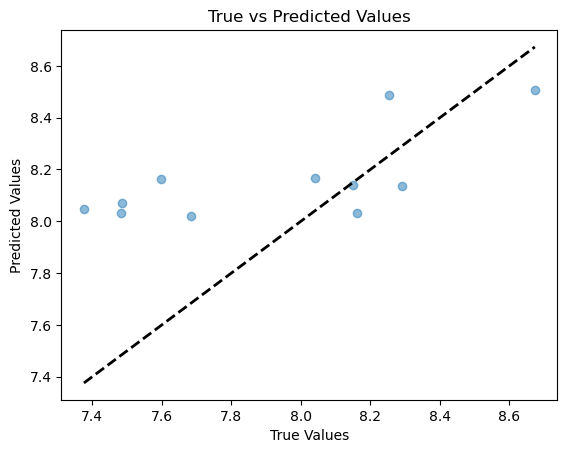

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=150, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred = rf_model.predict(X_test)

# Evaluate the model (for example, using Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Print the R-squared value
print(f"R-squared: {r2}")


# Scatter plot of true vs predicted values
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('True vs Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# Plot a diagonal line for reference
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--k', linewidth=2)


# Show the plot
plt.show()


In [115]:
from sklearn.impute import KNNImputer
lags = 9

# Create a list to store lagged DataFrames
lagged_dfs = []

# Loop over each column in last_10_df
for col in last_10_df.columns.difference(['temp']):
    # Create lagged features and store in a new DataFrame
    lagged_var_df = pd.DataFrame({f'{col}_Last_10_Lag_{i}': last_10_df[col].shift(i) for i in range(1, lags + 1)})
    lagged_dfs.append(lagged_var_df)

# Concatenate lagged DataFrames along columns
lagged_last_10_df = pd.concat([last_10_df] + lagged_dfs, axis=1)

# Create the imputer
knn_imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors

# Fit and transform your DataFrame
lagged_last_10_df = pd.DataFrame(knn_imputer.fit_transform(lagged_last_10_df), columns=lagged_last_10_df.columns)

# Separate the target variable (e.g., 'Temp') from the features
target_variable = 'temp'  # Replace 'Temp' with your target variable name
y_temp = lagged_last_10_df['temp'].values
X_features = lagged_last_10_df.drop('temp', axis=1).values


In [116]:
lagged_last_10_df

,wind,rain,hurs,temp,temp_max,temp_min,sun,frost,psl,wind_january_mean,...,wind_october_mean_Last_10_Lag_9,wind_september_mean_Last_10_Lag_1,wind_september_mean_Last_10_Lag_2,wind_september_mean_Last_10_Lag_3,wind_september_mean_Last_10_Lag_4,wind_september_mean_Last_10_Lag_5,wind_september_mean_Last_10_Lag_6,wind_september_mean_Last_10_Lag_7,wind_september_mean_Last_10_Lag_8,wind_september_mean_Last_10_Lag_9
0,4.834601,86.690861,81.861543,8.331636,12.019215,4.692388,100.345287,8.484588,1015.759422,3.427624,...,5.015066,5.030306,4.693173,4.892140,4.837255,4.861793,4.796036,4.920190,4.684507,3.827331
1,4.720519,87.422505,81.558932,7.926364,11.810089,4.078036,128.692580,8.110867,1013.381737,4.501244,...,5.015066,3.827331,4.693173,4.916678,4.837255,4.861793,4.796036,4.920190,4.684507,3.827331
2,5.077425,104.443877,82.745502,8.240718,11.725283,4.805187,110.504980,7.656735,1014.766221,5.643784,...,5.015066,5.541684,3.827331,4.861793,4.697005,4.861793,4.796036,4.920190,4.684507,3.827331
3,4.526567,94.220402,82.818667,7.946173,11.409120,4.538359,112.821837,9.371727,1012.216213,5.892262,...,5.015066,5.391556,5.541684,3.827331,4.861793,4.861793,4.796036,4.920190,4.684507,3.827331
4,4.747761,85.571894,83.776019,8.321629,11.876405,4.820485,100.752006,8.692015,1011.578786,4.643774,...,5.015066,4.423572,5.391556,5.541684,3.827331,4.861793,4.796036,4.920190,4.684507,3.827331
5,4.703949,85.006963,82.736233,8.786913,12.605681,5.016754,127.276079,11.409686,1013.372485,5.571372,...,5.015066,5.124824,4.423572,5.391556,5.541684,3.827331,4.796036,4.920190,4.684507,3.827331
6,4.525941,91.894731,82.909138,8.826152,12.586717,5.114336,111.187867,7.091708,1013.463286,4.672153,...,5.015066,4.300881,5.124824,4.423572,5.391556,5.541684,3.827331,4.920190,4.684507,3.827331
7,4.947384,67.751293,83.738650,8.489316,12.174830,4.843119,110.081285,8.914920,1013.346449,5.614673,...,5.015066,5.399248,4.300881,5.124824,4.423572,5.391556,5.541684,3.827331,4.684507,3.827331
8,4.404922,83.365335,81.377878,8.222669,11.840358,4.647744,111.309865,9.568828,1013.612814,5.506216,...,5.015066,4.281723,5.399248,4.300881,5.124824,4.423572,5.391556,5.541684,3.827331,3.827331
9,4.698671,78.171466,83.344048,8.301653,11.888651,4.759464,108.214376,6.518477,1010.160164,4.432479,...,5.015066,5.266136,4.281723,5.399248,4.300881,5.124824,4.423572,5.391556,5.541684,3.827331


In [117]:
# Assuming rf_model is your trained Random Forest model
future_predictions = rf_model.predict(X_features)

print(future_predictions)
print(future_predictions.shape)

[8.40153778 8.11838055 8.16490332 8.07875517 8.22889543 8.63013147
 8.60579605 8.57936626 8.17372585 8.20659746]
(10,)


In [122]:
import pandas as pd

time = np.arange(2013,2023)
# Assuming X_temp and future_predictions are NumPy arrays
comparison_df = pd.DataFrame({
    'Year': time.flatten(),
    'Actual Temperature': y_temp.flatten(),  
    'Predicted Temperature': future_predictions
})

# Display the DataFrame
print(comparison_df)


   Year  Actual Temperature  Predicted Temperature
0  2013            8.331636               8.401538
1  2014            7.926364               8.118381
2  2015            8.240718               8.164903
3  2016            7.946173               8.078755
4  2017            8.321629               8.228895
5  2018            8.786913               8.630131
6  2019            8.826152               8.605796
7  2020            8.489316               8.579366
8  2021            8.222669               8.173726
9  2022            8.301653               8.206597


In [119]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

r2 = r2_score(comparison_df['Actual_Temp'], comparison_df['Predicted_Temp'])
print(f"R-squared: {r2}")


mae = mean_absolute_error(comparison_df['Actual_Temp'], comparison_df['Predicted_Temp'])
print(f"Mean Absolute Error: {mae}")


mse = mean_squared_error(comparison_df['Actual_Temp'], comparison_df['Predicted_Temp'])
print(f"Mean Squared Error: {mse}")

R-squared: 0.7946338458083609
Mean Absolute Error: 0.1174235234866499
Mean Squared Error: 0.016635913531299083


Text(0, 0.5, 'Residuals')

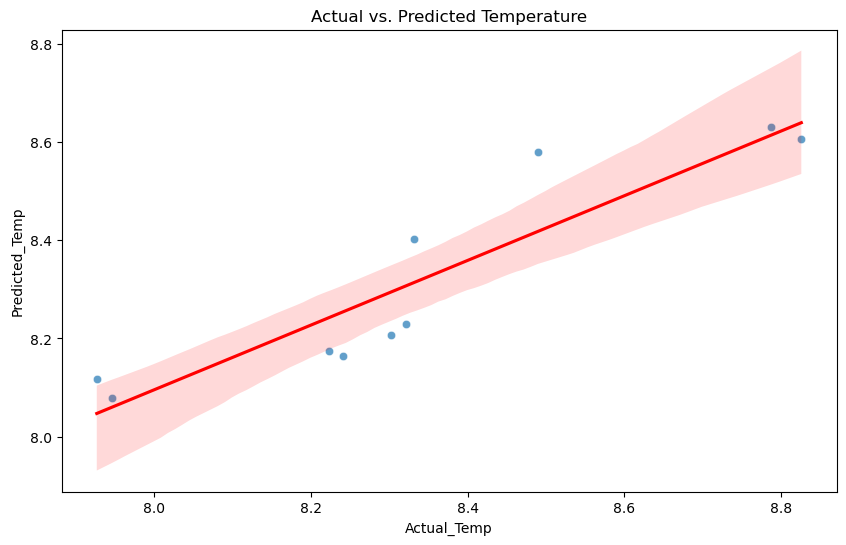

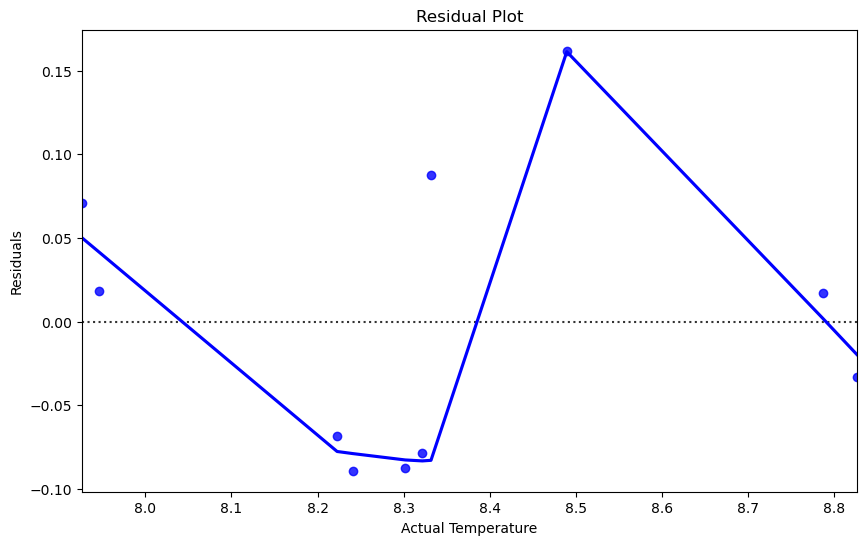

In [120]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual_Temp', y='Predicted_Temp', data=comparison_df, alpha=0.7)
plt.title('Actual vs. Predicted Temperature')
plt.xlabel('Actual Temperature')
plt.ylabel('Predicted Temperature')

# Regression line
sns.regplot(x='Actual_Temp', y='Predicted_Temp', data=comparison_df, scatter=False, color='red')

# Residual plot
plt.figure(figsize=(10, 6))
sns.residplot(x='Actual_Temp', y='Predicted_Temp', data=comparison_df, lowess=True, color='blue')
plt.title('Residual Plot')
plt.xlabel('Actual Temperature')
plt.ylabel('Residuals')

## PSL prediction

In [141]:
# Lagged features
lags = 9 

# Create a list to store lagged DataFrames
lagged_dfs = []

# Loop over all columns in the trimmed_df except 'Temp'
for col in trimmed_df.columns.difference(['psl']):
    # Create lagged features and store in a new DataFrame
    lagged_var_df = pd.DataFrame({f'{col}_Lag_{i}': trimmed_df[col].shift(i) for i in range(1, lags + 1)})
    lagged_dfs.append(lagged_var_df)

# Concatenate lagged DataFrames along columns
lagged_df_psl = pd.concat([trimmed_df] + lagged_dfs, axis=1)

# Drop rows with NaN values introduced by lagging
lagged_df_psl = lagged_df_psl.dropna()

# Target variable (future temperatures over the entire grid)
y = lagged_df_psl['psl'].values

# Features
X = lagged_df_psl.drop(['psl'], axis=1).values
X_no_psl = lagged_df_psl.drop(['psl'], axis=1)

In [142]:
X_no_psl

,wind,rain,hurs,temp,temp_max,temp_min,sun,frost,wind_january_mean,wind_february_mean,...,wind_october_mean_Lag_9,wind_september_mean_Lag_1,wind_september_mean_Lag_2,wind_september_mean_Lag_3,wind_september_mean_Lag_4,wind_september_mean_Lag_5,wind_september_mean_Lag_6,wind_september_mean_Lag_7,wind_september_mean_Lag_8,wind_september_mean_Lag_9
9,5.020279,86.243187,83.427779,8.750207,12.838864,4.709172,114.907213,9.871324,4.888509,3.884277,...,4.416769,4.569717,4.006977,3.921862,3.895480,4.696826,5.012407,4.716429,5.100342,6.839803
10,5.161575,88.933301,83.533916,8.160631,11.904184,4.470072,102.259552,9.047407,5.806225,5.081782,...,4.785333,4.821619,4.569717,4.006977,3.921862,3.895480,4.696826,5.012407,4.716429,5.100342
11,5.076797,80.728978,83.429417,7.493051,11.476708,3.583091,122.976522,9.381932,4.842628,4.649843,...,4.662284,4.857853,4.821619,4.569717,4.006977,3.921862,3.895480,4.696826,5.012407,4.716429
12,5.090883,98.786154,82.823855,8.248645,12.000842,4.575148,108.833815,10.391473,4.836133,5.160225,...,4.301014,4.369084,4.857853,4.821619,4.569717,4.006977,3.921862,3.895480,4.696826,5.012407
13,4.987185,83.030737,82.555451,8.205667,11.891442,4.576033,105.814065,9.160236,5.928310,4.295100,...,5.883523,4.434266,4.369084,4.857853,4.821619,4.569717,4.006977,3.921862,3.895480,4.696826
14,5.136326,79.604363,82.530156,8.839535,12.589455,5.138052,101.941602,10.142004,5.787095,5.064148,...,4.121263,4.683669,4.434266,4.369084,4.857853,4.821619,4.569717,4.006977,3.921862,3.895480
15,4.654632,75.939807,81.893746,8.550383,12.563592,4.599697,113.681723,9.908445,5.829493,5.029092,...,4.253105,5.263023,4.683669,4.434266,4.369084,4.857853,4.821619,4.569717,4.006977,3.921862
16,4.705839,105.073392,83.231109,8.237909,11.952649,4.574730,107.526309,9.347098,4.972710,5.648389,...,3.720288,4.990535,5.263023,4.683669,4.434266,4.369084,4.857853,4.821619,4.569717,4.006977
17,5.348541,78.745826,84.174001,8.039716,11.920222,4.219263,103.785280,9.213711,4.316288,8.055440,...,4.598671,4.634923,4.990535,5.263023,4.683669,4.434266,4.369084,4.857853,4.821619,4.569717
18,4.436863,75.704386,83.767062,7.684511,11.263836,4.141805,113.416503,11.689648,5.304447,7.254219,...,4.290546,3.704535,4.634923,4.990535,5.263023,4.683669,4.434266,4.369084,4.857853,4.821619


Mean Squared Error: 1.9687334902255167
R-squared: -0.3767874594411489


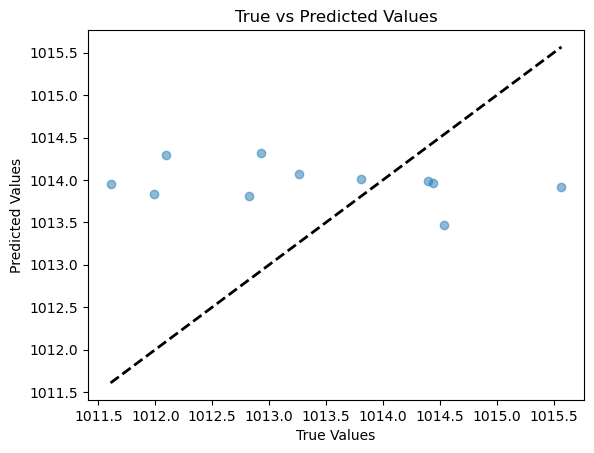

In [143]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=150, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred = rf_model.predict(X_test)

# Evaluate the model (for example, using Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Print the R-squared value
print(f"R-squared: {r2}")


# Scatter plot of true vs predicted values
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('True vs Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# Plot a diagonal line for reference
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--k', linewidth=2)


# Show the plot
plt.show()


In [144]:
from sklearn.impute import KNNImputer
lags = 9

# Create a list to store lagged DataFrames
lagged_dfs = []

# Loop over each column in last_10_df
for col in last_10_df.columns.difference(['psl']):
    # Create lagged features and store in a new DataFrame
    lagged_var_df = pd.DataFrame({f'{col}_Last_10_Lag_{i}': last_10_df[col].shift(i) for i in range(1, lags + 1)})
    lagged_dfs.append(lagged_var_df)

# Concatenate lagged DataFrames along columns
lagged_last_10_psl_df = pd.concat([last_10_df] + lagged_dfs, axis=1)

# Create the imputer
knn_imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors

# Fit and transform your DataFrame
lagged_last_10_psl_df = pd.DataFrame(knn_imputer.fit_transform(lagged_last_10_psl_df), columns=lagged_last_10_psl_df.columns)

# Separate the target variable (e.g., 'Temp') from the features
target_variable = 'psl'  # Replace 'Temp' with your target variable name
y_psl = lagged_last_10_psl_df['psl'].values
X_features_psl = lagged_last_10_psl_df.drop('psl', axis=1).values

In [145]:
lagged_last_10_psl_df

,wind,rain,hurs,temp,temp_max,temp_min,sun,frost,psl,wind_january_mean,...,wind_october_mean_Last_10_Lag_9,wind_september_mean_Last_10_Lag_1,wind_september_mean_Last_10_Lag_2,wind_september_mean_Last_10_Lag_3,wind_september_mean_Last_10_Lag_4,wind_september_mean_Last_10_Lag_5,wind_september_mean_Last_10_Lag_6,wind_september_mean_Last_10_Lag_7,wind_september_mean_Last_10_Lag_8,wind_september_mean_Last_10_Lag_9
0,4.834601,86.690861,81.861543,8.331636,12.019215,4.692388,100.345287,8.484588,1015.759422,3.427624,...,5.015066,5.030306,4.693173,4.892140,4.837255,4.861793,4.796036,4.920190,4.684507,3.827331
1,4.720519,87.422505,81.558932,7.926364,11.810089,4.078036,128.692580,8.110867,1013.381737,4.501244,...,5.015066,3.827331,4.693173,4.916678,4.837255,4.861793,4.796036,4.920190,4.684507,3.827331
2,5.077425,104.443877,82.745502,8.240718,11.725283,4.805187,110.504980,7.656735,1014.766221,5.643784,...,5.015066,5.541684,3.827331,4.861793,4.697005,4.861793,4.796036,4.920190,4.684507,3.827331
3,4.526567,94.220402,82.818667,7.946173,11.409120,4.538359,112.821837,9.371727,1012.216213,5.892262,...,5.015066,5.391556,5.541684,3.827331,4.861793,4.861793,4.796036,4.920190,4.684507,3.827331
4,4.747761,85.571894,83.776019,8.321629,11.876405,4.820485,100.752006,8.692015,1011.578786,4.643774,...,5.015066,4.423572,5.391556,5.541684,3.827331,4.861793,4.796036,4.920190,4.684507,3.827331
5,4.703949,85.006963,82.736233,8.786913,12.605681,5.016754,127.276079,11.409686,1013.372485,5.571372,...,5.015066,5.124824,4.423572,5.391556,5.541684,3.827331,4.796036,4.920190,4.684507,3.827331
6,4.525941,91.894731,82.909138,8.826152,12.586717,5.114336,111.187867,7.091708,1013.463286,4.672153,...,5.015066,4.300881,5.124824,4.423572,5.391556,5.541684,3.827331,4.920190,4.684507,3.827331
7,4.947384,67.751293,83.738650,8.489316,12.174830,4.843119,110.081285,8.914920,1013.346449,5.614673,...,5.015066,5.399248,4.300881,5.124824,4.423572,5.391556,5.541684,3.827331,4.684507,3.827331
8,4.404922,83.365335,81.377878,8.222669,11.840358,4.647744,111.309865,9.568828,1013.612814,5.506216,...,5.015066,4.281723,5.399248,4.300881,5.124824,4.423572,5.391556,5.541684,3.827331,3.827331
9,4.698671,78.171466,83.344048,8.301653,11.888651,4.759464,108.214376,6.518477,1010.160164,4.432479,...,5.015066,5.266136,4.281723,5.399248,4.300881,5.124824,4.423572,5.391556,5.541684,3.827331


In [146]:
# Assuming rf_model is your trained Random Forest model
future_predictions_psl = rf_model.predict(X_features_psl)

print(future_predictions_psl)
print(future_predictions_psl.shape)

[1013.85109517 1013.77002125 1013.79136032 1013.81488313 1013.9010644
 1013.93847758 1013.92875884 1013.68690411 1013.92466588 1014.054791  ]
(10,)


In [147]:
import pandas as pd

time = np.arange(2013,2023)
# Assuming X_temp and future_predictions are NumPy arrays
comparison_df = pd.DataFrame({
    'Year': time.flatten(),
    'Actual PSL': y_psl.flatten(),  
    'Predicted PSL': future_predictions_psl
})

# Display the DataFrame
print(comparison_df)


   Year   Actual PSL  Predicted PSL
0  2013  1015.759422    1013.851095
1  2014  1013.381737    1013.770021
2  2015  1014.766221    1013.791360
3  2016  1012.216213    1013.814883
4  2017  1011.578786    1013.901064
5  2018  1013.372485    1013.938478
6  2019  1013.463286    1013.928759
7  2020  1013.346449    1013.686904
8  2021  1013.612814    1013.924666
9  2022  1010.160164    1014.054791


In [148]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

r2 = r2_score(comparison_df['Actual PSL'], comparison_df['Predicted PSL'])
print(f"R-squared: {r2}")


mae = mean_absolute_error(comparison_df['Actual PSL'], comparison_df['Predicted PSL'])
print(f"Mean Absolute Error: {mae}")


mse = mean_squared_error(comparison_df['Actual PSL'], comparison_df['Predicted PSL'])
print(f"Mean Squared Error: {mse}")

R-squared: -0.2914835287741959
Mean Absolute Error: 1.277081920283274
Mean Squared Error: 2.8609842682211615


Text(0, 0.5, 'Residuals')

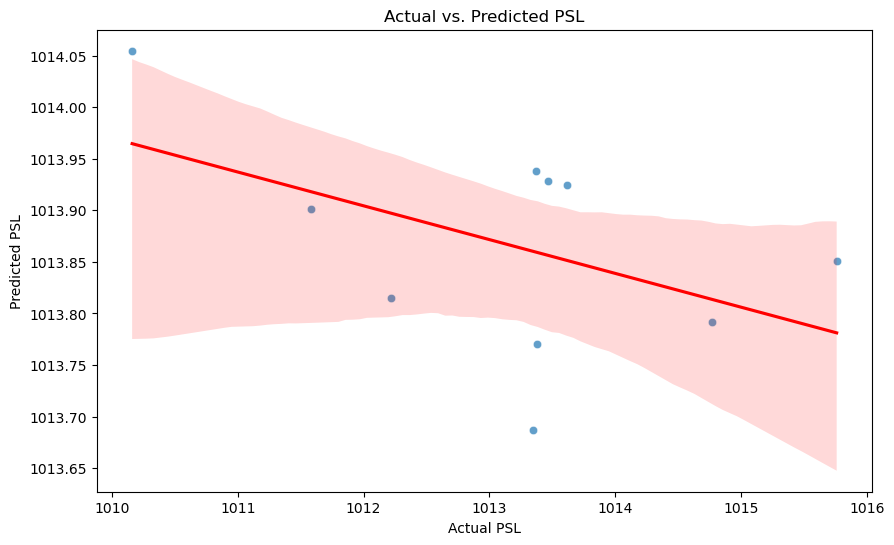

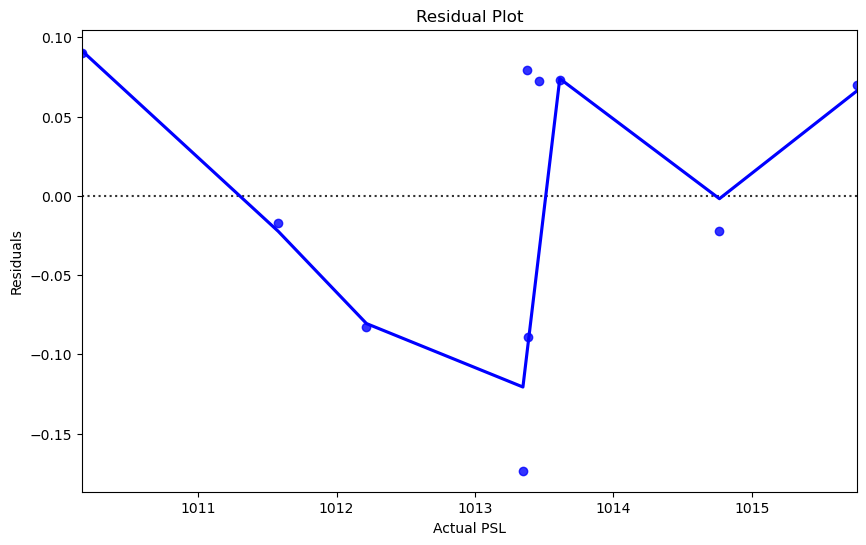

In [149]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual PSL', y='Predicted PSL', data=comparison_df, alpha=0.7)
plt.title('Actual vs. Predicted PSL')
plt.xlabel('Actual PSL')
plt.ylabel('Predicted PSL')

# Regression line
sns.regplot(x='Actual PSL', y='Predicted PSL', data=comparison_df, scatter=False, color='red')

# Residual plot
plt.figure(figsize=(10, 6))
sns.residplot(x='Actual PSL', y='Predicted PSL', data=comparison_df, lowess=True, color='blue')
plt.title('Residual Plot')
plt.xlabel('Actual PSL')
plt.ylabel('Residuals')

## Hurs Prediction

In [150]:
# Lagged features
lags = 9 

# Create a list to store lagged DataFrames
lagged_dfs = []

# Loop over all columns in the trimmed_df except 'Temp'
for col in trimmed_df.columns.difference(['hurs']):
    # Create lagged features and store in a new DataFrame
    lagged_var_df = pd.DataFrame({f'{col}_Lag_{i}': trimmed_df[col].shift(i) for i in range(1, lags + 1)})
    lagged_dfs.append(lagged_var_df)

# Concatenate lagged DataFrames along columns
lagged_df_hurs = pd.concat([trimmed_df] + lagged_dfs, axis=1)

# Drop rows with NaN values introduced by lagging
lagged_df_hurs = lagged_df_hurs.dropna()

# Target variable (future temperatures over the entire grid)
y = lagged_df_hurs['hurs'].values

# Features
X = lagged_df_hurs.drop(['hurs'], axis=1).values
X_no_hurs = lagged_df_hurs.drop(['hurs'], axis=1)

In [151]:
X_no_hurs

,wind,rain,temp,temp_max,temp_min,sun,frost,psl,wind_january_mean,wind_february_mean,...,wind_october_mean_Lag_9,wind_september_mean_Lag_1,wind_september_mean_Lag_2,wind_september_mean_Lag_3,wind_september_mean_Lag_4,wind_september_mean_Lag_5,wind_september_mean_Lag_6,wind_september_mean_Lag_7,wind_september_mean_Lag_8,wind_september_mean_Lag_9
9,5.020279,86.243187,8.750207,12.838864,4.709172,114.907213,9.871324,1012.752102,4.888509,3.884277,...,4.416769,4.569717,4.006977,3.921862,3.895480,4.696826,5.012407,4.716429,5.100342,6.839803
10,5.161575,88.933301,8.160631,11.904184,4.470072,102.259552,9.047407,1015.525351,5.806225,5.081782,...,4.785333,4.821619,4.569717,4.006977,3.921862,3.895480,4.696826,5.012407,4.716429,5.100342
11,5.076797,80.728978,7.493051,11.476708,3.583091,122.976522,9.381932,1013.569310,4.842628,4.649843,...,4.662284,4.857853,4.821619,4.569717,4.006977,3.921862,3.895480,4.696826,5.012407,4.716429
12,5.090883,98.786154,8.248645,12.000842,4.575148,108.833815,10.391473,1016.914965,4.836133,5.160225,...,4.301014,4.369084,4.857853,4.821619,4.569717,4.006977,3.921862,3.895480,4.696826,5.012407
13,4.987185,83.030737,8.205667,11.891442,4.576033,105.814065,9.160236,1011.952350,5.928310,4.295100,...,5.883523,4.434266,4.369084,4.857853,4.821619,4.569717,4.006977,3.921862,3.895480,4.696826
14,5.136326,79.604363,8.839535,12.589455,5.138052,101.941602,10.142004,1016.521341,5.787095,5.064148,...,4.121263,4.683669,4.434266,4.369084,4.857853,4.821619,4.569717,4.006977,3.921862,3.895480
15,4.654632,75.939807,8.550383,12.563592,4.599697,113.681723,9.908445,1014.908059,5.829493,5.029092,...,4.253105,5.263023,4.683669,4.434266,4.369084,4.857853,4.821619,4.569717,4.006977,3.921862
16,4.705839,105.073392,8.237909,11.952649,4.574730,107.526309,9.347098,1012.669043,4.972710,5.648389,...,3.720288,4.990535,5.263023,4.683669,4.434266,4.369084,4.857853,4.821619,4.569717,4.006977
17,5.348541,78.745826,8.039716,11.920222,4.219263,103.785280,9.213711,1012.818885,4.316288,8.055440,...,4.598671,4.634923,4.990535,5.263023,4.683669,4.434266,4.369084,4.857853,4.821619,4.569717
18,4.436863,75.704386,7.684511,11.263836,4.141805,113.416503,11.689648,1011.606891,5.304447,7.254219,...,4.290546,3.704535,4.634923,4.990535,5.263023,4.683669,4.434266,4.369084,4.857853,4.821619


Mean Squared Error: 1.6429208730512606
R-squared: -0.2046276946872927


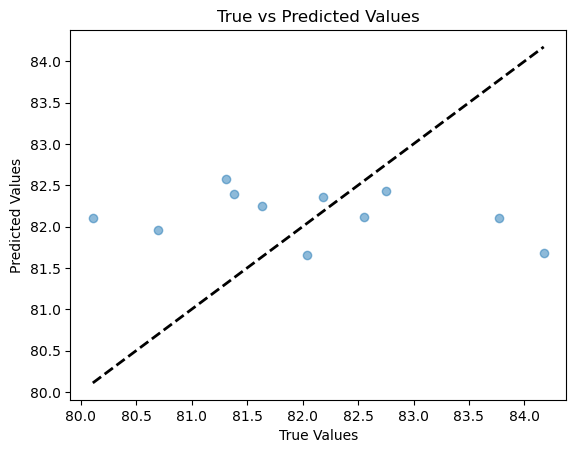

In [152]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=150, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred = rf_model.predict(X_test)

# Evaluate the model (for example, using Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Print the R-squared value
print(f"R-squared: {r2}")


# Scatter plot of true vs predicted values
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('True vs Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# Plot a diagonal line for reference
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--k', linewidth=2)


# Show the plot
plt.show()


In [154]:
from sklearn.impute import KNNImputer
lags = 9

# Create a list to store lagged DataFrames
lagged_dfs = []

# Loop over each column in last_10_df
for col in last_10_df.columns.difference(['hurs']):
    # Create lagged features and store in a new DataFrame
    lagged_var_df = pd.DataFrame({f'{col}_Last_10_Lag_{i}': last_10_df[col].shift(i) for i in range(1, lags + 1)})
    lagged_dfs.append(lagged_var_df)

# Concatenate lagged DataFrames along columns
lagged_last_10_hurs_df = pd.concat([last_10_df] + lagged_dfs, axis=1)

# Create the imputer
knn_imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors

# Fit and transform your DataFrame
lagged_last_10_hurs_df = pd.DataFrame(knn_imputer.fit_transform(lagged_last_10_hurs_df), columns=lagged_last_10_hurs_df.columns)

# Separate the target variable (e.g., 'Temp') from the features
target_variable = 'hurs'  # Replace 'Temp' with your target variable name
y_hurs = lagged_last_10_df['hurs'].values
X_features_hurs = lagged_last_10_df.drop('hurs', axis=1).values

In [155]:
# Assuming rf_model is your trained Random Forest model
future_predictions_hurs = rf_model.predict(X_features_hurs)

print(future_predictions_hurs)
print(future_predictions_hurs.shape)

[82.36414153 82.24950148 82.24798141 82.19333511 82.31540149 82.16132173
 82.08781459 82.09890424 82.03143843 82.30893616]
(10,)


In [156]:
import pandas as pd

time = np.arange(2013,2023)
# Assuming X_temp and future_predictions are NumPy arrays
comparison_df = pd.DataFrame({
    'Year': time.flatten(),
    'Actual Hurs': y_hurs.flatten(),  
    'Predicted Hurs': future_predictions_hurs
})

# Display the DataFrame
print(comparison_df)

   Year  Actual Hurs  Predicted Hurs
0  2013    81.861543       82.364142
1  2014    81.558932       82.249501
2  2015    82.745502       82.247981
3  2016    82.818667       82.193335
4  2017    83.776019       82.315401
5  2018    82.736233       82.161322
6  2019    82.909138       82.087815
7  2020    83.738650       82.098904
8  2021    81.377878       82.031438
9  2022    83.344048       82.308936


In [157]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

r2 = r2_score(comparison_df['Actual Hurs'], comparison_df['Predicted Hurs'])
print(f"R-squared: {r2}")


mae = mean_absolute_error(comparison_df['Actual Hurs'], comparison_df['Predicted Hurs'])
print(f"Mean Absolute Error: {mae}")


mse = mean_squared_error(comparison_df['Actual Hurs'], comparison_df['Predicted Hurs'])
print(f"Mean Squared Error: {mse}")

R-squared: -0.3449991945878925
Mean Absolute Error: 0.8501292458250262
Mean Squared Error: 0.8693923676591135


Text(0, 0.5, 'Residuals')

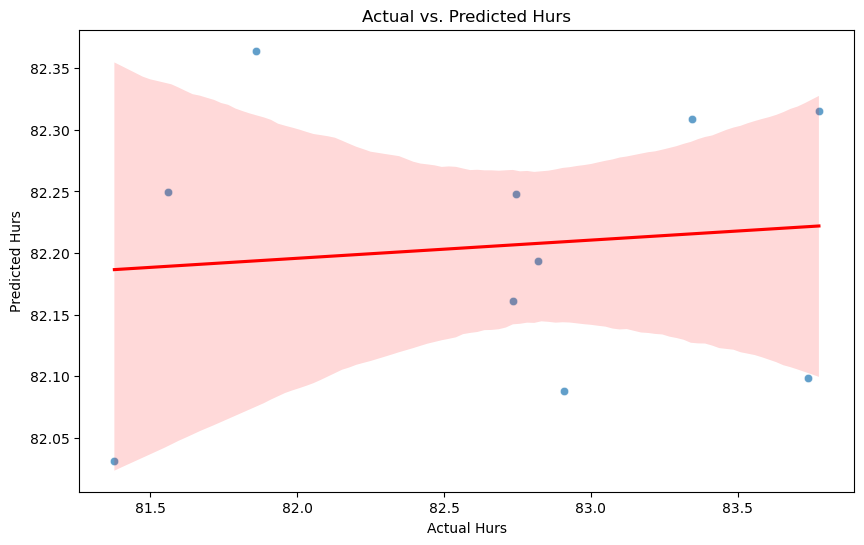

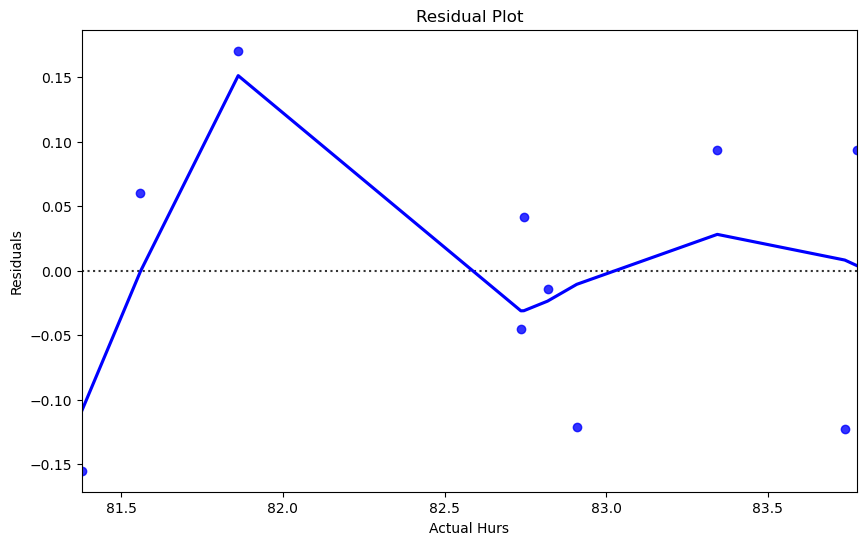

In [158]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual Hurs', y='Predicted Hurs', data=comparison_df, alpha=0.7)
plt.title('Actual vs. Predicted Hurs')
plt.xlabel('Actual Hurs')
plt.ylabel('Predicted Hurs')

# Regression line
sns.regplot(x='Actual Hurs', y='Predicted Hurs', data=comparison_df, scatter=False, color='red')

# Residual plot
plt.figure(figsize=(10, 6))
sns.residplot(x='Actual Hurs', y='Predicted Hurs', data=comparison_df, lowess=True, color='blue')
plt.title('Residual Plot')
plt.xlabel('Actual Hurs')
plt.ylabel('Residuals')